In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [65]:
df = pd.read_csv("TSLA.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)


# EDA (Rolling Mean)

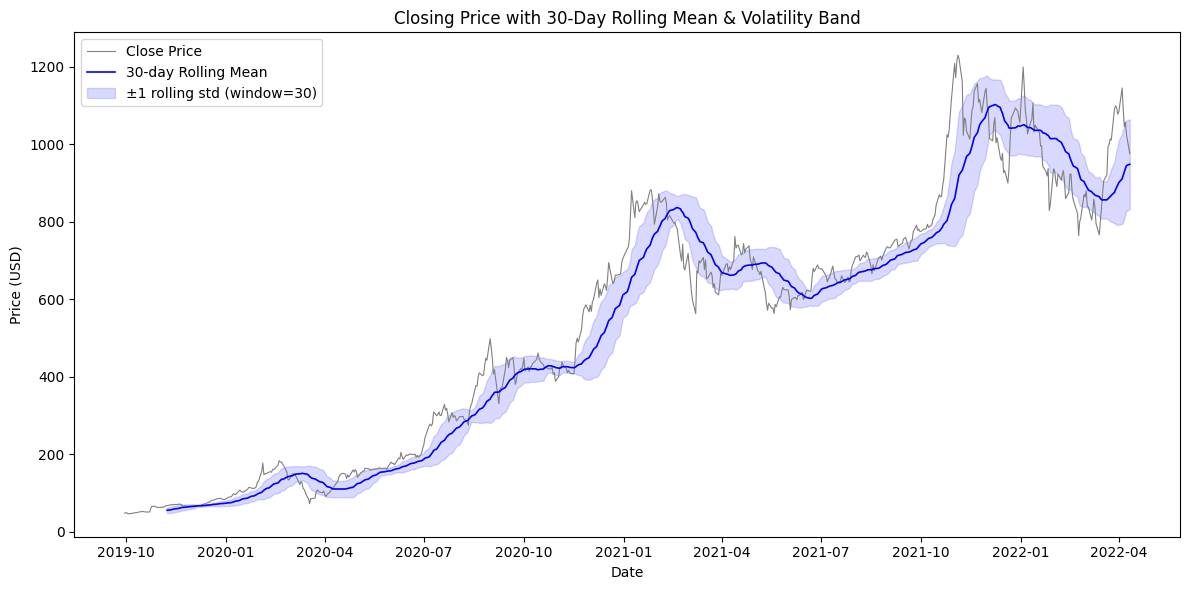

In [40]:
import matplotlib.pyplot as plt

# (1) Choose a window length—e.g. 30 trading days
window = 30

# (2) Compute 30-day rolling mean (trend) and rolling std (volatility)
df["Close_RollMean"] = df["Close"].rolling(window=window).mean()
df["Close_RollStd"]  = df["Close"].rolling(window=window).std()

# (3) Plot in one chart: price, rolling mean, and rolling‐std as a shaded band
plt.figure(figsize=(12, 6))

# Plot raw closing price
plt.plot(df.index, df["Close"], color="grey", linewidth=0.8, label="Close Price")

# Plot rolling mean
plt.plot(df.index, df["Close_RollMean"], color="blue", linewidth=1.2, label=f"{window}-day Rolling Mean")

# Shade ±1 rolling-std around the rolling mean to visualize volatility
upper_band = df["Close_RollMean"] + df["Close_RollStd"]
lower_band = df["Close_RollMean"] - df["Close_RollStd"]
plt.fill_between(
    df.index,
    lower_band,
    upper_band,
    color="blue",
    alpha=0.15,
    label=f"±1 rolling std (window={window})"
)

plt.title("Closing Price with 30-Day Rolling Mean & Volatility Band")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


# EDA ( Heat Map)

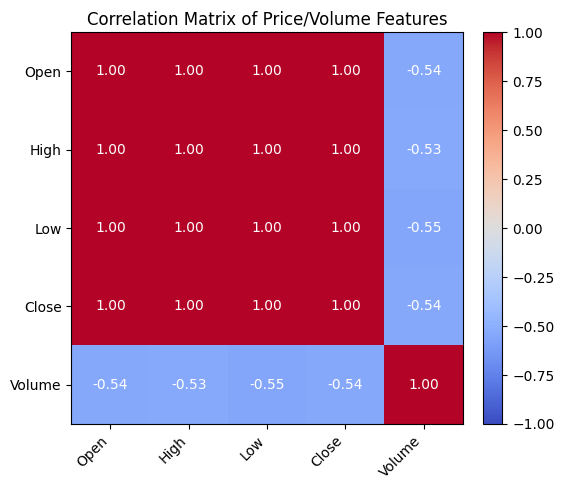

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# (1) Select only numeric columns (e.g. Open, High, Low, Close, Volume)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
sub = df[numeric_cols].copy()

# (2) Compute pairwise correlations
corr = sub.corr()

# (3) Plot heatmap using Matplotlib's imshow
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

# (4) Annotate tick labels
plt.xticks(np.arange(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(np.arange(len(numeric_cols)), numeric_cols)

# (5) Annotate correlation values on the heatmap
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        text = f"{corr.iloc[i, j]:.2f}"
        plt.text(j, i, text, ha="center", va="center", color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

plt.title("Correlation Matrix of Price/Volume Features")
plt.tight_layout()
plt.show()


In [64]:
df1 =df[["Close"]].copy()
ts = df1["Close"].asfreq("D")
ts[90:100]

Date
2019-12-29          NaN
2019-12-30    82.940002
2019-12-31    83.666000
2020-01-01          NaN
2020-01-02    86.052002
2020-01-03    88.601997
2020-01-04          NaN
2020-01-05          NaN
2020-01-06    90.307999
2020-01-07    93.811996
Freq: D, Name: Close, dtype: float64

925


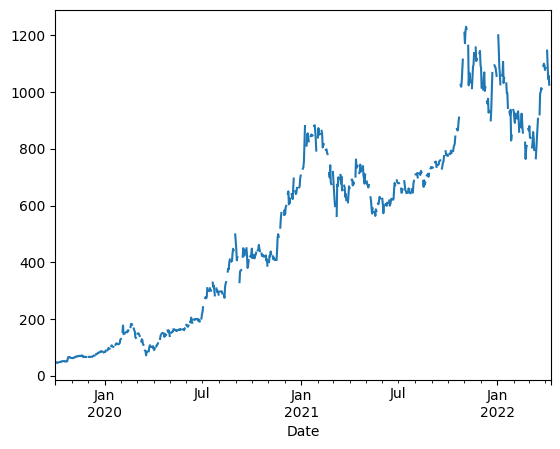

In [46]:
ts.plot()
print(len(ts))

<Axes: xlabel='Date'>

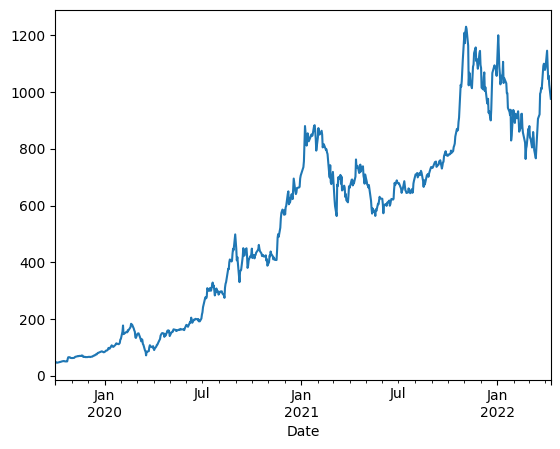

In [47]:

ts =ts.interpolate()
ts.plot()

In [48]:
#Check if price series is stationary ( p value must be <0.05 )
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts.dropna())
print(f"ADF Statistics {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistics -1.1194459275753905
p-value: 0.7072551256477164


# Plot ACF to find differencing


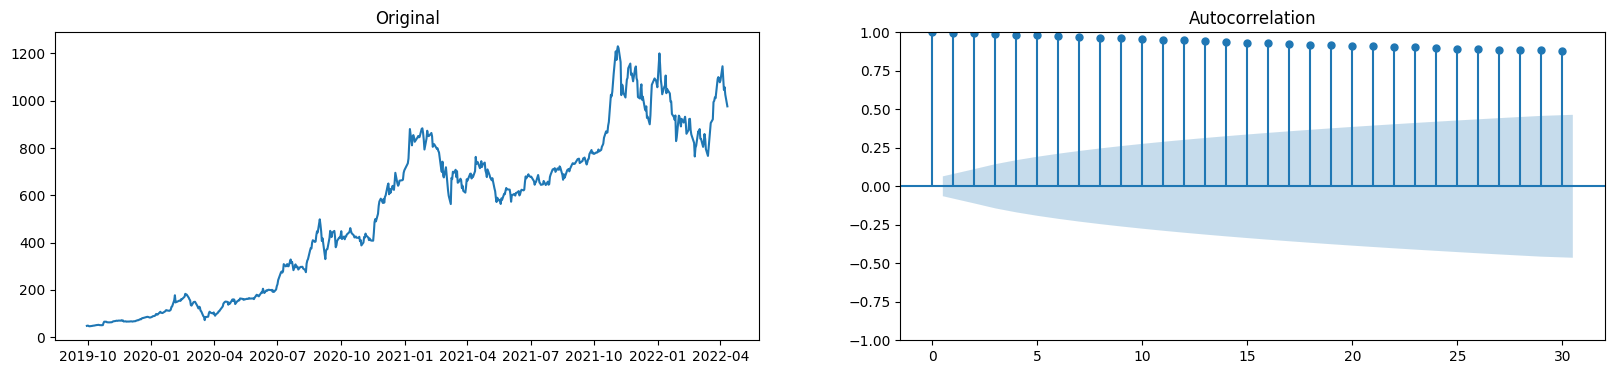

In [49]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,4))

ax1.plot(ts)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(ts, ax=ax2);

In [50]:
#print(ts.diff)

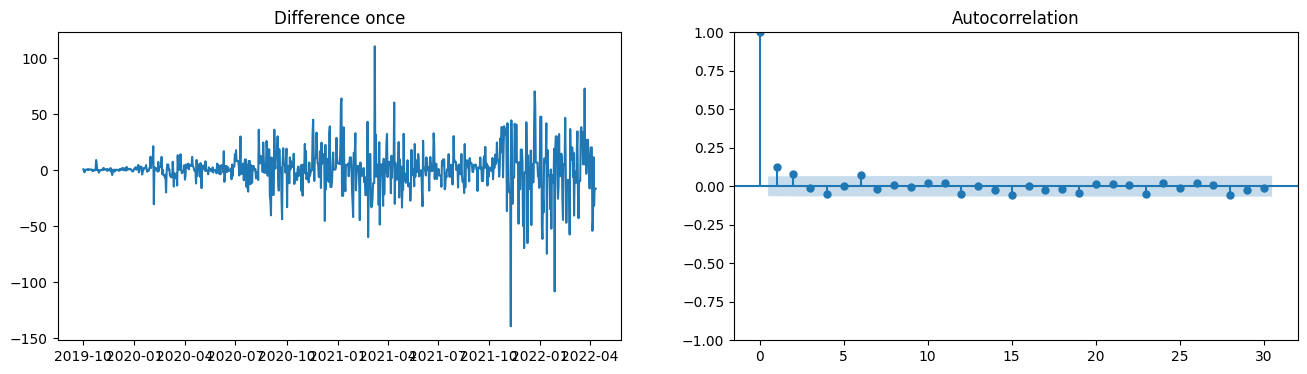

In [51]:
diff = ts.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2);

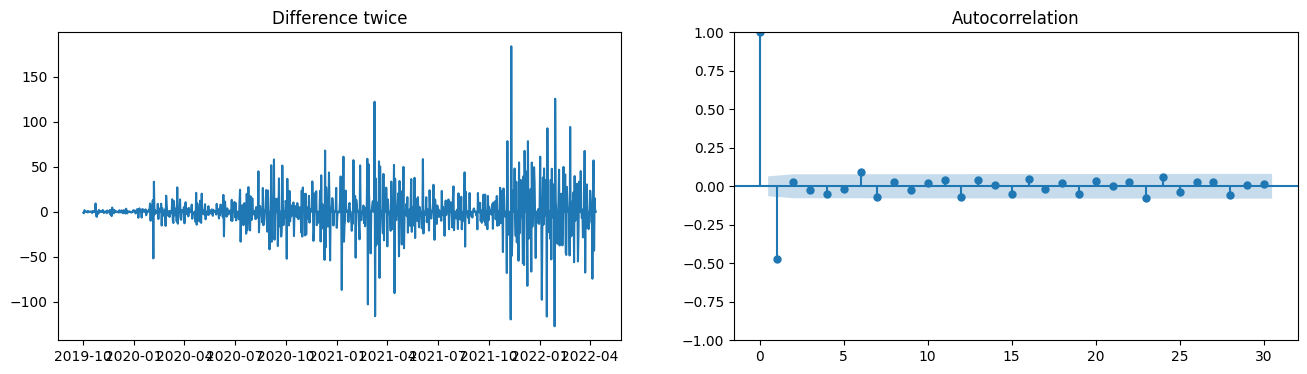

In [52]:
diff = ts.diff().diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2);

In [54]:
from pmdarima.arima.utils import ndiffs
ndiffs(ts, test="adf")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

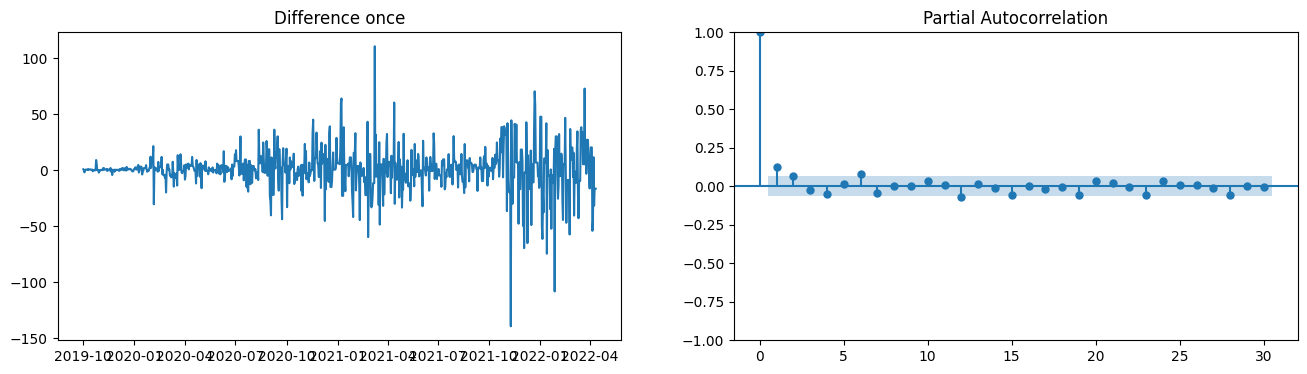

In [55]:
from statsmodels.graphics.tsaplots import plot_pacf
diff = ts.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

In [56]:
from statsmodels.tsa.stattools import acf, pacf

acf_vals = acf(diff)
pacf_vals = pacf(diff)

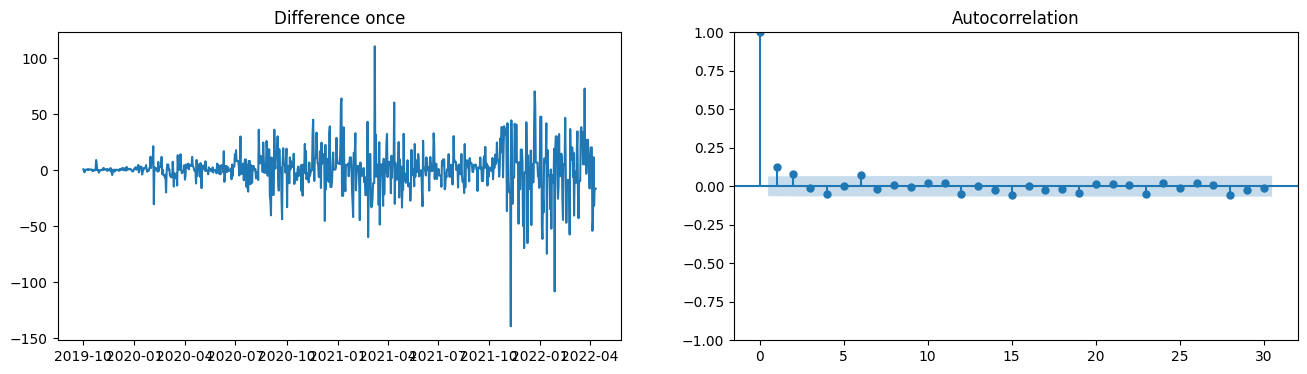

In [57]:
diff = ts.diff().dropna()

fig, (ax1, ax2) =plt.subplots(1,2,figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

In [58]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(diff)
print(f"ADF p-value: {adf_result[1]}")


ADF p-value: 2.9283003634550584e-20


In [59]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts)
print(f"ADF p-value: {adf_result[1]}")


ADF p-value: 0.7072551256477164


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  925
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -3950.820
Date:                Fri, 06 Jun 2025   AIC                           7917.640
Time:                        01:40:59   BIC                           7956.269
Sample:                    09-30-2019   HQIC                          7932.378
                         - 04-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2587      0.222     -1.165      0.244      -0.694       0.176
ar.L2          0.1256      0.035      3.629      0.000       0.058       0.193
ar.L3          0.0113      0.035      0.328      0.7

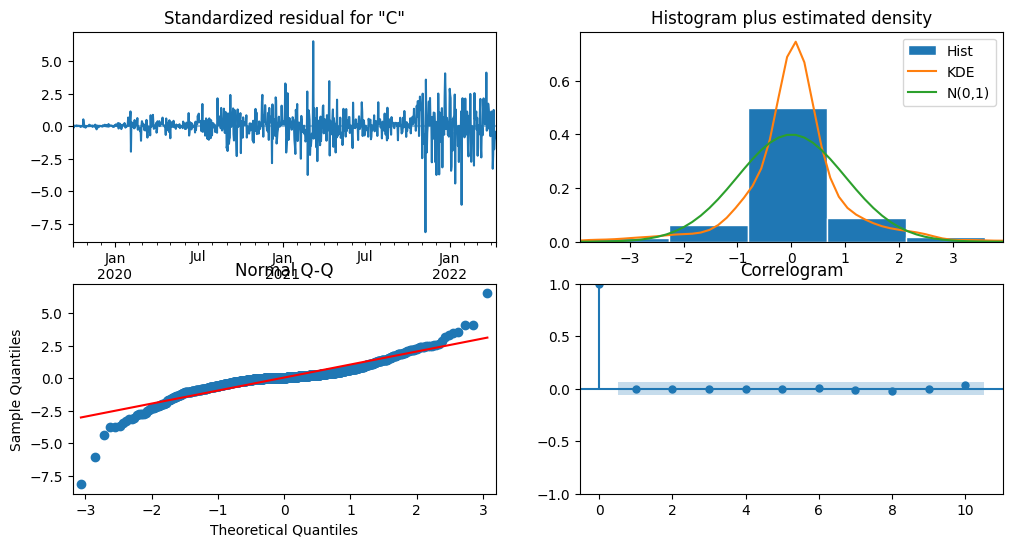

In [60]:
from statsmodels.tsa.arima.model import ARIMA  

#ARIMA Model
model =ARIMA(ts, order=(6,1,1))
result=model.fit()

# Plot diagnostics
result.plot_diagnostics(figsize=(12, 6))

print(result.summary())

(array([4.24095445e-05, 4.24095445e-05, 1.27228634e-04, 7.20962257e-04,
        3.47758265e-03, 2.84992139e-02, 5.13155489e-03, 1.06023861e-03,
        8.48190890e-05, 4.24095445e-05]),
 array([-141.58518778, -116.09373077,  -90.60227376,  -65.11081675,
         -39.61935974,  -14.12790273,   11.36355428,   36.85501129,
          62.3464683 ,   87.83792531,  113.32938232]),
 <BarContainer object of 10 artists>)

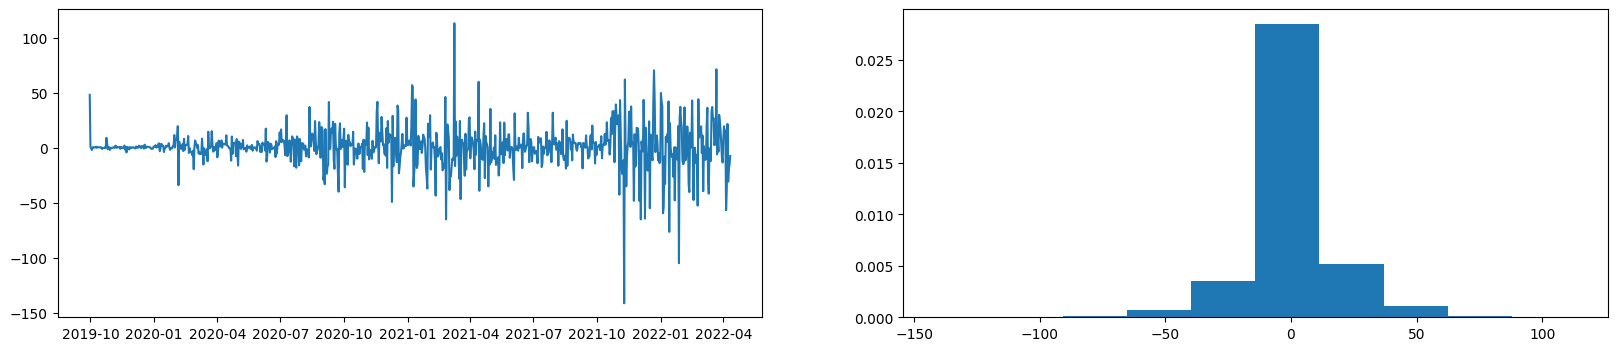

In [61]:
#Plot residuals

residuals=pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

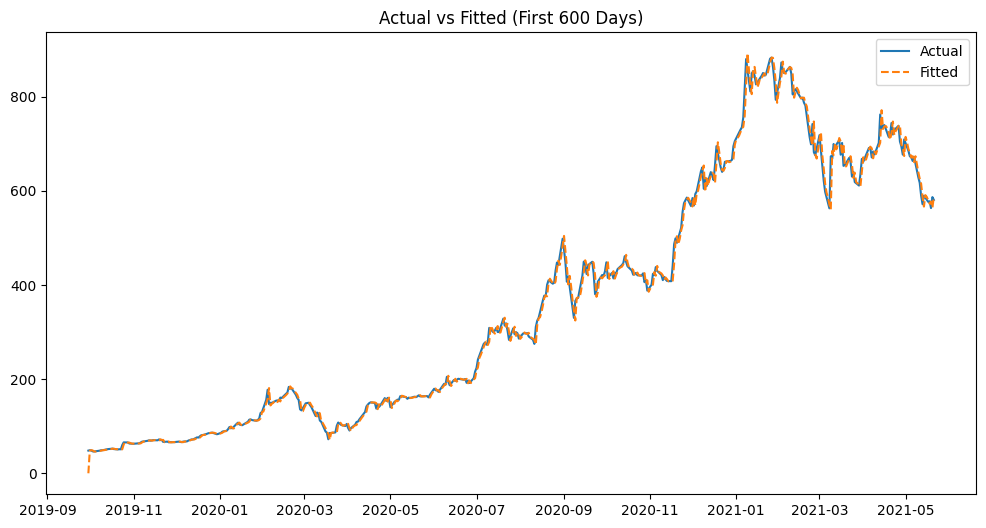

In [ ]:
# Actual vs Fitted
import matplotlib.pyplot as plt

# Define date range
start_date = ts.index[0]
end_date = ts.index[599]

# Predict values in the specified range
fitted_values = result.predict(start=start_date, end=end_date)

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(ts[start_date:end_date], label="Actual")
plt.plot(fitted_values, label="Fitted", linestyle="--")
plt.title("Actual vs Fitted (First 600 Days)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

fitted_values = result.predict().dropna()
actual_values = ts[fitted_values.index]

rmse = root_mean_squared_error(actual_values, fitted_values)
print(f"RMSE: {rmse:.4f}")


RMSE: 17.4681
